# End-to-end AutoEmulate workflow 

## Overview

<!-- <b>In this workflow we demonstrate the integration of a Cardiovascular simulator, Naghavi Model from ModularCirc in an end-to-end AutoEmulate workflow.</b>  -->

Naghavi model is a 0D (zero-dimensional) computational model of the cardiovascular system, which is used to simulate blood flow and pressure dynamics in the heart and blood vessels.

This demo includes:
- Setting up parameter ranges 
- Creating samples
- Running the simulator to generate training data for the emulator 
- Using AutoEmulate to find the best pre-processing technique and model tailored to the simulation data 
- Applying history matching to refine the model and enhance parameter ranges 
- Sensitivity Analysis 
- Bayesian calibration

TODO: update figure?
<!-- <img src="https://raw.githubusercontent.com/alan-turing-institute/autoemulate/refs/heads/main/misc/workflow.png" alt="Work Flow" style="width:100%;"/> -->


In [1]:
import pandas as pd
import torch

## 1: Set up simulator and generate data

TODO: add link here to how subclass the `Simulator` class to integrate their own simulator into an `AutoEmulate` workflow (see `docs/experimental/tutorials/simulator/01_custom_simulations.ipynb`)

Below we import all that we need.

The `NaghaviSimulator` models a range of parameters. Below we choose to only track a subset of those. Note that the simulator is set up to output summary statistics for each of the tracked variables.

In [2]:
from cardiac_simulator import NaghaviSimulator

simulator = NaghaviSimulator(
    output_variables=['lv.P_i', 'lv.P_o'],  # Only the ones you're interested in
    n_cycles=300, 
    dt=0.001,
)

The simulator comes with predefined input parameters ranges. We can sample from those using Latin Hypercube Sampling to generate data to train the emulator with.

In [3]:
simulator.parameters_range

{'ao.r': (120.0, 360.0),
 'ao.c': (0.15, 0.44999999999999996),
 'art.r': (562.5, 1687.5),
 'art.c': (1.5, 4.5),
 'ven.r': (4.5, 13.5),
 'ven.c': (66.65, 199.95000000000002),
 'av.r': (3.0, 9.0),
 'mv.r': (2.05, 6.1499999999999995),
 'la.E_pas': (0.22, 0.66),
 'la.E_act': (0.225, 0.675),
 'la.v_ref': (5.0, 15.0),
 'la.k_pas': (0.01665, 0.07500000000000001),
 'lv.E_pas': (0.5, 1.5),
 'lv.E_act': (1.5, 4.5),
 'lv.v_ref': (5.0, 15.0),
 'lv.k_pas': (0.00999, 0.045)}

In [4]:
N_samples = 1024
x = simulator.sample_inputs(N_samples,random_seed=42)

We can now use the simulator to generate predictions for the sampled parameters. Alternatively, for convenience. we can load already simulated data.

In [5]:
import os
save = True

if not os.path.exists(f'simulator_results_{N_samples}.csv'):
    # Run batch simulations with the samples generated in Cell 1
    y, x = simulator.forward_batch_skip_failures(x)
    
    # Convert results to DataFrame for analysis
    results_df = pd.DataFrame(y)
    inputs_df = pd.DataFrame(x)
    
    if save:
        # Save the results to a CSV file
        results_df.to_csv(f'simulator_results_{N_samples}.csv', index=False)
        inputs_df.to_csv(f'simulator_inputs_{N_samples}.csv', index=False)

else:
    # Read the results from the CSV file
    results_df = pd.read_csv(f'simulator_results_{N_samples}.csv')
    inputs_df = pd.read_csv(f'simulator_inputs_{N_samples}.csv')

    y = torch.tensor(results_df.to_numpy())
    x = torch.tensor(inputs_df.to_numpy())

Running simulations: 100%|██████████| 1.02k/1.02k [04:16<00:00, 4.00sample/s] 


These are the output variables we've simulated.

In [6]:
simulator.output_names

['lv.P_i_min',
 'lv.P_i_max',
 'lv.P_i_mean',
 'lv.P_i_range',
 'lv.P_o_min',
 'lv.P_o_max',
 'lv.P_o_mean',
 'lv.P_o_range']

## 2: Train emulator with AutoEmulate
 
User should choose from the available `models` the `models` they would like to investigate. Here we restrict to just Gaussian Processes as we need an uncertainty aware emulator.

TODO: below we also use PCA to reduce dimensionality of the outputs but we should not do this if we're working with summary statistics.

In [7]:
from autoemulate.experimental.compare import AutoEmulate

from autoemulate.experimental.emulators.nn.mlp import MLP

ae = AutoEmulate(
    x, 
    y, 
    models=[MLP],  
)

Comparing models: 100%|██████████| 1.00/1.00 [02:01<00:00, 121s/model]


TODO: the GPs are not doing great here

In [8]:
ae.summarise()

,model_name,x_transforms,y_transforms,config,rmse_test,r2_test,r2_test_std,r2_train,r2_train_std
0,MLP,[StandardizeTransform()],[StandardizeTransform()],"{'epochs': 200, 'layer_dims': [64, 32, 16], 'l...",1.411958,0.930369,0.010917,0.992585,0.000461


Extract the best performing emulator.

In [9]:
model = ae.best_result().model

## 3: Sensitivity Analysis 
Use AutoEmulate to perform sensitivity analysis. This will help identify the parameters that have higher impact on the outputs to narrow down the search space for performing model calibration. 

TODO: could link to sensitivity analysis overview notebook.

In [10]:
from autoemulate.experimental.sensitivity_analysis import SensitivityAnalysis

# Define the problem dictionary for Sobol sensitivity analysis
problem = {
    'num_vars': simulator.in_dim,
    'names': simulator.param_names,
    'bounds': simulator.param_bounds
}

si = SensitivityAnalysis(model, problem=problem)

In [11]:
si_df = si.run(method='sobol')


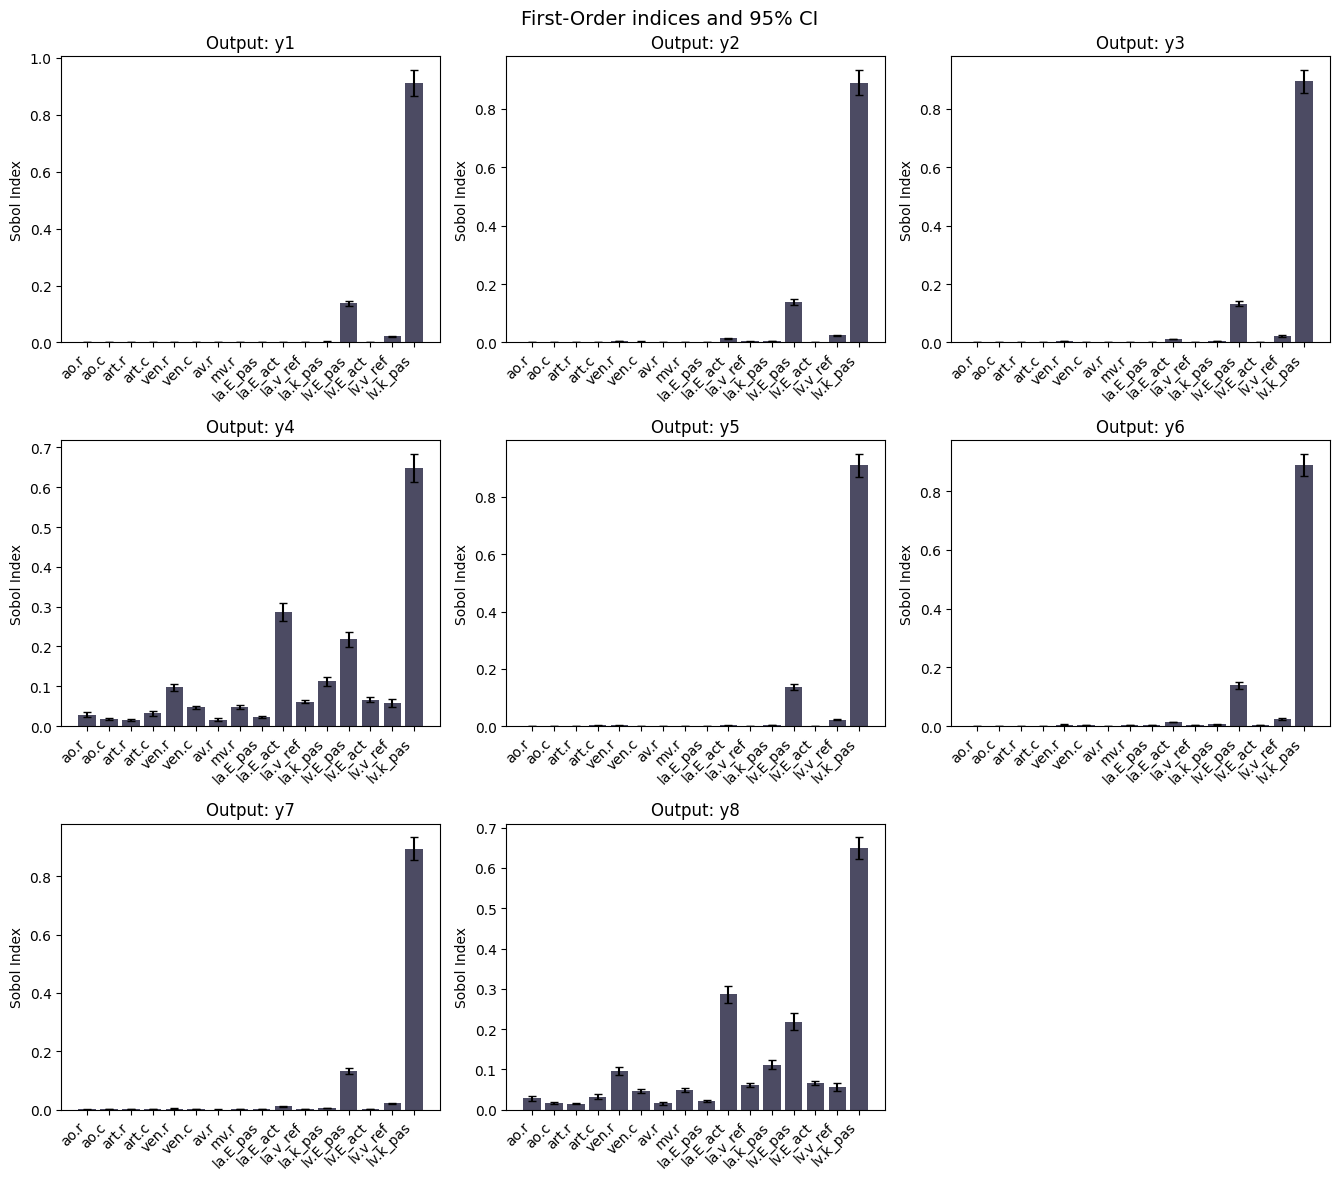

In [12]:
si.plot_sobol(si_df)

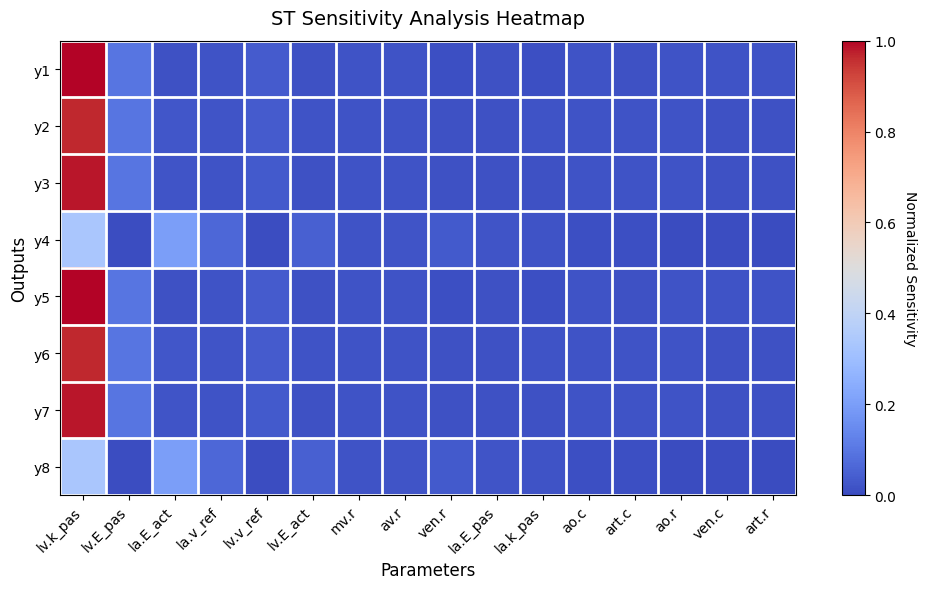

In [13]:
si.plot_sa_heatmap(si_df, index='ST', cmap='coolwarm', normalize=True, figsize=(10, 6))

In [14]:
top_parameters_sa = si.top_n_sobol_params(si_df,top_n=5)
top_parameters_sa

['lv.k_pas', 'lv.E_pas', 'la.E_act', 'la.v_ref', 'lv.v_ref']

In [15]:
# TODO simulator.param_names update to include only the top N parameters from sensitivity analysis fixing to a value the rest 

updated_range = {}
for param_name, (min_val, max_val) in simulator.parameters_range.items():
    if param_name not in top_parameters_sa:
        print(f"Fixing parameter {param_name} to a value within its range ({min_val}, {max_val})")
        midpoint_value = (max_val + min_val) / 2.0
        updated_range[param_name] = (midpoint_value,midpoint_value)
    else:
        updated_range[param_name] = simulator.parameters_range[param_name]# Fix to a value
        
print("Updated parameters range with fixed values for non-sensitive parameters:")
print(updated_range)

Fixing parameter ao.r to a value within its range (120.0, 360.0)
Fixing parameter ao.c to a value within its range (0.15, 0.44999999999999996)
Fixing parameter art.r to a value within its range (562.5, 1687.5)
Fixing parameter art.c to a value within its range (1.5, 4.5)
Fixing parameter ven.r to a value within its range (4.5, 13.5)
Fixing parameter ven.c to a value within its range (66.65, 199.95000000000002)
Fixing parameter av.r to a value within its range (3.0, 9.0)
Fixing parameter mv.r to a value within its range (2.05, 6.1499999999999995)
Fixing parameter la.E_pas to a value within its range (0.22, 0.66)
Fixing parameter la.k_pas to a value within its range (0.01665, 0.07500000000000001)
Fixing parameter lv.E_act to a value within its range (1.5, 4.5)
Updated parameters range with fixed values for non-sensitive parameters:
{'ao.r': (240.0, 240.0), 'ao.c': (0.3, 0.3), 'art.r': (1125.0, 1125.0), 'art.c': (3.0, 3.0), 'ven.r': (9.0, 9.0), 'ven.c': (133.3, 133.3), 'av.r': (6.0, 6.0),

In [16]:
simulator.parameters_range = updated_range

## 4: Model calibration

To refine our emulator, we need real-world observations to compare against. These observations can come from experiments reported in the literature. 

In this example, we'll generate synthetic "observations" by running the simulator at the midpoint of each parameter range, treating these as our "ground truth" values for calibration. Note that in a real world example one can have multiple observations.

In [17]:
# An example of how to define observed data with means and variances from a hypothetical experiment
observations = {
    'lv.P_i_min': (5.0, 0.1),   # Minimum of minimum LV pressure
    'lv.P_i_max': (20.0, 0.1),   # Maximum of minimum LV pressure
    'lv.P_i_mean': (10.0, 0.1),  # Mean of minimum LV pressure
    'lv.P_i_range': (15.0, 0.5), # Range of minimum LV pressure
    'lv.P_o_min': (1.0, 0.1),  # Minimum of maximum LV pressure
    'lv.P_o_max': (13.0, 0.1),  # Maximum of maximum LV pressure
    'lv.P_o_mean': (12.0, 0.1), # Mean of maximum LV pressure
    'lv.P_o_range': (20.0, 0.5)  # Range of maximum LV pressure
}

In [18]:
# Otherwise, use one forward pass of your simualtion to get the observed data
# Calculate midpoint parameters
midpoint_params = []
for param_name in simulator.parameters_range:
    # Calculate the midpoint of the parameter range
    min_val, max_val = simulator.parameters_range[param_name]
    midpoint_params.append((max_val + min_val) / 2.0)

# Run the simulator with midpoint parameters
midpoint_results = simulator.forward(torch.tensor(midpoint_params).reshape(1, -1))

In [19]:
# Create observations dictionary
observations = {
    name: (val.item(), max(abs(val.item()) * 0.01, 0.01)) for
    name, val in 
    zip(simulator.output_names, midpoint_results[0])}
observations


{'lv.P_i_min': (12.257057189941406, 0.12257057189941406),
 'lv.P_i_max': (22.596208572387695, 0.22596208572387697),
 'lv.P_i_mean': (20.69025421142578, 0.20690254211425782),
 'lv.P_i_range': (10.339152336120605, 0.10339152336120605),
 'lv.P_o_min': (12.257057189941406, 0.12257057189941406),
 'lv.P_o_max': (22.596208572387695, 0.22596208572387697),
 'lv.P_o_mean': (20.69025421142578, 0.20690254211425782),
 'lv.P_o_range': (10.339152336120605, 0.10339152336120605)}

### History Matching
 
Once you have the final model, running history matching can improve your model. The Implausibility metric is calculated using the following relation for each set of parameter:

$I_i(\overline{x_0}) = \frac{|z_i - \mathbb{E}(f_i(\overline{x_0}))|}{\sqrt{\text{Var}[z_i - \mathbb{E}(f_i(\overline{x_0}))]}}$
Where if implosibility ($I_i$) exceeds a threshhold value, the points will be rulled out. 
The outcome of history matching are the NORY (Not Ruled Out Yet) and RO (Ruled Out) points.

- create a dictionary of your observations, this should match the output names of your simulator 
- create the history matching object 
- run history matching 


In [20]:
from autoemulate.experimental.emulators.gaussian_process.exact import GaussianProcessExact

ae_hm = AutoEmulate(
    x, 
    y, 
    models=[GaussianProcessExact],  
)

model_hm = ae_hm.best_result().model


Comparing models: 100%|██████████| 1.00/1.00 [13:47<00:00, 827s/model]


In [22]:
from autoemulate.experimental.calibration.history_matching import HistoryMatchingWorkflow

hmw = HistoryMatchingWorkflow(
    simulator=simulator,
    emulator=model_hm,
    observations=observations,
    threshold=3.0,
    train_x=x.float(),
    train_y=y.float()
)

In [ ]:
# Save the results
history_matching_results = hmw.run_waves(n_waves=10, n_simulations=1024, n_test_samples=8192,max_retries=10)

Running simulations:  51%|█████     | 520/1.02k [02:58<01:34, 5.34sample/s]   

In [ ]:
#get last values from HM
test_parameters, impl_scores = history_matching_results[-1]
nory_points = hmw.get_nroy(impl_scores,test_parameters) # Implausibility < 3.0


In [ ]:
from autoemulate.experimental.calibration.history_matching_dashboard import HistoryMatchingDashboard
dashboard = HistoryMatchingDashboard(
    samples=test_parameters,
    impl_scores=impl_scores,
    param_names=simulator.param_names,  
    output_names=simulator.output_names, 
    )
dashboard.display()

In [ ]:
params_post_hm = hmw.generate_param_bounds(nroy_x=nory_points,param_names=simulator.param_names)

In [ ]:
params_post_hm

In [ ]:
simulator.parameters_range

### Bayesian calibration
Once you have identified the important parameters through the Sensitivity analysis tool, the MCMC module can return the calibrated parameter values with uncertainty. 
The MCMC algorithm tries to find parameter values that match the predictions by the emulator to your `observations` whilst staying within the `parameters_range` (priors)
and accounting for uncertainty.

TODO: link to tutorial (once added). This will show 

In [ ]:
# with sensitivity analysis, can choose N top params to calibrate
# n_top = 2
# top_params = si.top_n_sobol_params(si_df, n_top)

In [ ]:
torch.tensor(list({k: v[0] for k,v in observations.items()}.values())).ndim

In [ ]:
!pip install arviz

In [ ]:
from autoemulate.experimental.calibration.bayes import BayesianCalibration

bc = BayesianCalibration(
    model,
    # the parameter range here could be narrowd using history matching
    # specifically the `hm.generate_param_bounds` method
    simulator.parameters_range,
    observations = {k: torch.tensor(v[0]) for k,v in observations.items()},
    observation_noise={k: v[1] for k,v in observations.items()},
    # if had top N sensitive params, could pass those here
    calibration_params = top_parameters_sa
)

mcmc = bc.run_mcmc(warmup_steps=10, num_samples=10, sampler='nuts')


In [ ]:
mcmc.summary()